In [48]:
import simpy
import random
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Containers
#   crude container
crudeCon_capacity = 1000
crudeCon_initial = 500
#   product container
prodCon_capacity = 500

# Machines
#   maker
num_maker = 1


#-------------------------------------------------
class Factory:
    def __init__(self, env):
        self.env = env
        
        # 定义两个容器 (Container)
        # 一个用来存放原材料，一个用来存放加工后的材料
        self.crudeCon = simpy.Container(env, capacity=crudeCon_capacity, init = crudeCon_initial)
        self.prodCon = simpy.Container(env ,capacity = prodCon_capacity, init = 0)
        
    # 定义一台 machine
    # [流程]: 从原料勇气中取出 2 个原材料，加工成 1 个产品，并放入产品容器
    # [时间]: 1 个时间单位
    def maker(self, num_maker):
        self.makers = simpy.Resource(env, num_maker)
        
    def make_product(self):
        yield self.crudeCon.get(2)
        process_time = 1
        yield self.env.timeout(process_time)
        yield self.prodCon.put(1)
#-------------------------------------------------
# 创建环境、工厂对象
env = simpy.Environment()
factory = Factory(env)
# 添加一台 machine
env.process(factory.maker())
# 模拟到第 50 个时间单位
env.run(until = 50)

print(f'%d products are finished!' % factory.prodCon.level)

49 products are finished!


# Basic Simulation

In [24]:
# Containers
    # crude container
crudeCon_capacity = 1000
crudeCon_initial = 500
    # product container
prodCon_capacity = 500
#-------------------------------------------------
class Factory:
    def __init__(self, env):
        self.env = env
        
        # 定义两个容器 (Container)
        # 一个用来存放原材料，一个用来存放加工后的材料
        self.crudeCon = simpy.Container(env, capacity=crudeCon_capacity, init = crudeCon_initial)
        self.prodCon = simpy.Container(env ,capacity = prodCon_capacity, init = 0)
        
    # 定义一台 machine
    # [流程]: 从原料勇气中取出 2 个原材料，加工成 1 个产品，并放入产品容器
    # [时间]: 1 个时间单位
    def maker(self):
        while True:
            yield self.crudeCon.get(2)
            process_time = 1
            yield self.env.timeout(process_time)
            yield self.prodCon.put(1)
#-------------------------------------------------
# 创建环境、工厂对象
env = simpy.Environment()
factory = Factory(env)
# 添加一台 machine
env.process(factory.maker())
# 模拟到第 50 个时间单位
env.run(until = 100)

print(f'%d products are finished!' % factory.prodCon.level)

99 products are finished!


In [21]:
# Number of parallel machines
num_maker = 2
num_painter = 3
num_assembler = 1

# Critial Stock Level (when reach, 触发警报并订货)
wood_critial_stock = 100
wood_order_amount = 300
wood_order_leadTime = 16

elec_critial_stock = 30
elec_order_amount = 50
elec_order_leadTime = 8 

class Guitar_Factory:
    def __init__(self, env):
        self.env = env
        
        # 定义五个容器 (Container)
        self.woodCon = simpy.Container(env, capacity=1000, init = 500)
        self.prePaintCon = simpy.Container(env, capacity=100, init = 0)
        self.postPaintCon = simpy.Container(env, capacity=200, init = 0)
        self.elecCon = simpy.Container(env, capacity=100, init = 100)
        self.guitarCon = simpy.Container(env ,capacity=1000, init = 0)
    # -----------------------------------------------------
    # 定义 machine
    # maker: 加工木头，制作成琴身
    def maker(self):
        while True:
            yield self.woodCon.get(2)
            process_time = random.gauss(1, 0.2)
            yield self.env.timeout(process_time)
            yield self.prePaintCon.put(1)
    # painter: 为琴身涂漆
    def painter(self):
        while True:
            yield self.prePaintCon.get(1)
            process_time = random.gauss(4, 1)
            yield self.env.timeout(process_time)
            yield self.postPaintCon.put(1)
    # assembler: 组装琴身、电子元件，制作成吉他
    def assembler(self):
        while True:
            yield self.postPaintCon.get(1)
            yield self.elecCon.get(1)
            process_time = 1
            yield self.env.timeout(process_time)
            yield self.guitarCon.put(1)
            
    # -----------------------------------------------------
    # 生成多个 parallel machines
    def makerGen(self): # maker Generator
        for i in range(num_maker):
            yield self.env.process(self.maker())
    def painterGen(self): # painter Generator
        for i in range(num_painter):
            yield self.env.process(self.painter())
    def assemblerGen(self): # assembler Generator
        for i in range(num_assembler):
            yield self.env.process(self.assembler())
    
    # -----------------------------------------------------
    # 定义库存报警
    def wood_stock_control(self):
        yield self.env.timeout(0)
        while True:
            if self.woodCon.level <= wood_critial_stock:
                # 触发警报
                print('Wood stock bellow critical level ({0}) at time {1}'.\
                    format(self.woodCon.level, int(self.env.now)))
                # 联系供应商，购买 300 个木材
                print('Calling wood supplier...')
                yield self.env.timeout(wood_order_leadTime)
                print('Wood supplier arrives at time {0}'.format(int(self.env.now)))
                yield self.woodCon.put(wood_order_amount)
                print('New wood stock is {0}'.format(self.woodCon.level))
                print('------------------------------------------')
                # 进货一次之后，至少再等 8 个时间单位才能重新检查库存
                yield self.env.timeout(8)
            else:
                # 如果没有触发警报，就每隔 1 个时间单位检查一次库存
                yield self.env.timeout(1)
    
    def elec_stock_control(self):
        yield self.env.timeout(0)
        while True:
            if self.elecCon.level <= elec_critial_stock:
                print('Elec stock bellow critical level ({0}) at time {1}'.\
                    format(self.elecCon.level, int(self.env.now)))
                print('Calling elec supplier...')
                yield self.env.timeout(16)
                print('Elec supplier arrives at time {0}'.format(int(self.env.now)))
                yield self.elecCon.put(50)
                print('New elec stock is {0}'.format(self.elecCon.level))
                print('------------------------------------------')
                yield self.env.timeout(8)
            else:
                yield self.env.timeout(1)

# 创建环境、工厂对象
env = simpy.Environment()
factory = Guitar_Factory(env)
# Add machines
env.process(factory.makerGen())
env.process(factory.painterGen())
env.process(factory.assemblerGen())
# Add alarm and replenishment
env.process(factory.wood_stock_control())
env.process(factory.elec_stock_control())
# Simulate to time 500
env.run(until = 500)

print(f'Pre-paint Container has %d bodies ready to be painted' % factory.prePaintCon.level)
print(f'Post-paint Container has %d bodies ready to be assembled' % factory.postPaintCon.level)
print(f'%d products are finished!' % factory.guitarCon.level)

Elec stock bellow critical level (30) at time 274
Calling elec supplier...
Elec supplier arrives at time 290
New elec stock is 77
------------------------------------------
Wood stock bellow critical level (100) at time 391
Calling wood supplier...
Wood supplier arrives at time 407
New wood stock is 390
------------------------------------------
Elec stock bellow critical level (30) at time 476
Calling elec supplier...
Elec supplier arrives at time 492
New elec stock is 77
------------------------------------------
Pre-paint Container has 100 bodies ready to be painted
Post-paint Container has 0 bodies ready to be assembled
125 products are finished!


In [12]:
wait_times = []

class Theater(object):
    def __init__(self, env, num_cashiers):
        self.env = env
        self.cashier = simpy.Resource(env, num_cashiers)

    def purchase_ticket(self, moviegoer):
        yield self.env.timeout(random.randint(1, 3))

def go_to_movies(env, moviegoer, theater):
    # Moviegoer arrives at the theater
    arrival_time = env.now

    with theater.cashier.request() as request:
        yield request
        yield env.process(theater.purchase_ticket(moviegoer))

    # Moviegoer heads into the theater
    wait_times.append(env.now - arrival_time)

def run_theater(env, num_cashiers):
    theater = Theater(env, num_cashiers)

    # 假设一开始电影院里有3个人
    for moviegoer in range(3):
        env.process(go_to_movies(env, moviegoer, theater))

    # 电影院里的人不断增加（每0.2分钟增加一个人）
    while True:
        yield env.timeout(0.20)
        moviegoer += 1
        env.process(go_to_movies(env, moviegoer, theater))

In [15]:
 # Setup
random.seed(42)
num_cashiers = 5

# Run the simulation
env = simpy.Environment()
env.process(run_theater(env, num_cashiers))
env.run(until=90)

# View the results
mins, secs = get_average_wait_time(wait_times)
print(
    "Running simulation...",
    f"\nThe average wait time is {mins} minutes and {secs} seconds.",
)

At 0, 0 enters the queue
At 0, 1 enters the queue
At 0, 2 enters the queue
At 0, 0 enters the cashier
At 0, 1 enters the cashier
At 0, 2 enters the cashier
At 0.2, 3 enters the queue
At 0.2, 3 enters the cashier
At 0.4, 4 enters the queue
At 0.4, 4 enters the cashier
At 0.6000000000000001, 5 enters the queue
At 0.8, 6 enters the queue
At 1.0, 7 enters the queue
At 1, 5 enters the cashier
At 1, 6 enters the cashier
At 1.2, 8 enters the queue
At 1.4, 9 enters the queue
At 1.5999999999999999, 10 enters the queue
At 1.7999999999999998, 11 enters the queue
At 1.9999999999999998, 12 enters the queue
At 2, 7 enters the cashier
At 2, 8 enters the cashier
At 2.1999999999999997, 13 enters the queue
At 2.4, 14 enters the queue
At 2.4, 9 enters the cashier
At 2.6, 15 enters the queue
At 2.8000000000000003, 16 enters the queue
At 3, 10 enters the cashier
At 3, 11 enters the cashier
At 3.0000000000000004, 17 enters the queue
At 3.2, 12 enters the cashier
At 3.2000000000000006, 18 enters the queue
At

In [3]:
import simpy
import random
import statistics

wait_times = []


class Theater(object):
    def __init__(self, env, num_cashiers, num_servers, num_ushers):
        self.env = env
        self.cashier = simpy.Resource(env, num_cashiers)
        self.server = simpy.Resource(env, num_servers)
        self.usher = simpy.Resource(env, num_ushers)

    def purchase_ticket(self, moviegoer):
        yield self.env.timeout(random.randint(1, 3))

    def check_ticket(self, moviegoer):
        yield self.env.timeout(3 / 60)

    def sell_food(self, moviegoer):
        yield self.env.timeout(random.randint(1, 5))


def go_to_movies(env, moviegoer, theater):
    # Moviegoer arrives at the theater
    arrival_time = env.now

    with theater.cashier.request() as request:
        yield request
        yield env.process(theater.purchase_ticket(moviegoer))

    with theater.usher.request() as request:
        yield request
        yield env.process(theater.check_ticket(moviegoer))

    if random.choice([True, False]):
        with theater.server.request() as request:
            yield request
            yield env.process(theater.sell_food(moviegoer))

    # Moviegoer heads into the theater
    wait_times.append(env.now - arrival_time)


def run_theater(env, num_cashiers, num_servers, num_ushers):
    theater = Theater(env, num_cashiers, num_servers, num_ushers)

    for moviegoer in range(3):
        env.process(go_to_movies(env, moviegoer, theater))

    while True:
        yield env.timeout(0.20)  # Wait a bit before generating a new person

        moviegoer += 1
        env.process(go_to_movies(env, moviegoer, theater))


def get_average_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    # Pretty print the results
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

In [6]:
    # Setup
    random.seed(42)
    num_cashiers, num_servers, num_ushers = [11, 6, 6]

    # Run the simulation
    env = simpy.Environment()
    env.process(run_theater(env, num_cashiers, num_servers, num_ushers))
    env.run(until=90)

    # View the results
    mins, secs = get_average_wait_time(wait_times)
    print(
        "Running simulation...",
        f"\nThe average wait time is {mins} minutes and {secs} seconds.",
    )

Running simulation... 
The average wait time is 6 minutes and 24 seconds.


In [44]:
6*transit_time + 2*(EPT_A + EPT_B + EPT_C)

6.303233574131407

In [53]:
# Factory throughput rate (jobs arrival rate)
TH_f = 1.5
# Jobs arrival time (time between two arrivals)
AT = 1/TH_f

# Effective processing rate of machines
EPR_A = 1.8
EPR_B = 0.85
EPR_C = 0.855

EPT_A = 1/EPR_A
EPT_B = 1/EPR_B
EPT_C = 1/EPR_C

transit_time = 5/60

class Factory:
    def __init__(self, env):
        self.env = env
        self.m_A = simpy.Resource(env, capacity=1) 
        self.m_Ap = simpy.Resource(env, capacity=1) # workstation A'
        self.m_B = simpy.Resource(env, capacity=2)
        self.m_Bp = simpy.Resource(env, capacity=2)
        self.m_C = simpy.Resource(env, capacity=2)
        self.m_Cp = simpy.Resource(env, capacity=2)

        self.jobsFinished = 0
        self.jobsCycleTime = []

    def run(self):
        while True:
            yield self.env.timeout(AT)
            self.env.process(self.jobIn())

    def jobIn(self):
        arrival_time = self.env.now

        yield self.env.timeout(transit_time)
        with self.m_A.request() as req:
            yield req
            yield self.env.timeout(EPT_A)
        yield self.env.timeout(transit_time)
        with self.m_B.request() as req:
            yield req
            yield self.env.timeout(EPT_B)
        yield self.env.timeout(transit_time)
        with self.m_C.request() as req:
            yield req
            yield self.env.timeout(EPT_C)
        yield self.env.timeout(transit_time)
        with self.m_Ap.request() as req:
            yield req
            yield self.env.timeout(EPT_A)
        yield self.env.timeout(transit_time)
        with self.m_Bp.request() as req:
            yield req
            yield self.env.timeout(EPT_B)
        yield self.env.timeout(transit_time)
        with self.m_Cp.request() as req:
            yield req
            yield self.env.timeout(EPT_C)

        departure_time = self.env.now
        self.jobsCycleTime.append(departure_time - arrival_time)
        self.jobsFinished += 1


env = simpy.Environment()
factory = Factory(env)
env.process(factory.run())
env.run(until=168)

0.6666666666666666
0.5
0.4
0.3333333333333333
0.2857142857142857
0.25
0.2222222222222222
0.2
0.18181818181818182
0.16666666666666666
0.15384615384615385


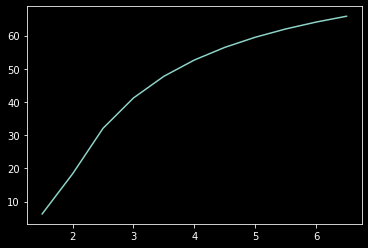

In [54]:
list_TH_f = [1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
list_AT = [1/TH_f for TH_f in list_TH_f]
list_CT = []

for AT in list_AT:
    print(AT)
    env = simpy.Environment()
    factory = Factory(env)
    env.process(factory.run())
    env.run(until=168)
    list_CT.append(statistics.mean(factory.jobsCycleTime))

plt.plot(list_TH_f, list_CT)


In [46]:
np.mean(factory.jobsCycleTime)

418.6015995872021

In [47]:
factory.jobsCycleTime

[6.303233574131408,
 6.758789129686963,
 7.279704162366701,
 7.735259717922256,
 8.256174750601996,
 8.711730306157552,
 9.23264533883729,
 9.688200894392844,
 10.209115927072585,
 10.66467148262814,
 11.185586515307879,
 11.641142070863435,
 12.162057103543173,
 12.617612659098729,
 13.138527691778467,
 13.594083247334023,
 14.11499828001376,
 14.570553835569317,
 15.091468868249054,
 15.547024423804611,
 16.067939456484346,
 16.523495012039906,
 17.04441004471964,
 17.499965600275196,
 18.020880632954935,
 18.47643618851049,
 18.99735122119023,
 19.452906776745785,
 19.97382180942552,
 20.42937736498108,
 20.950292397660814,
 21.40584795321637,
 21.926762985896108,
 22.382318541451664,
 22.9032335741314,
 23.358789129686958,
 23.879704162366693,
 24.335259717922252,
 24.856174750601987,
 25.311730306157543,
 25.83264533883728,
 26.288200894392837,
 26.809115927072575,
 27.26467148262813,
 27.78558651530787,
 28.241142070863425,
 28.762057103543167,
 29.217612659098727,
 29.7385276917